In [1]:
%matplotlib inline

In [2]:
%run proof_setup

In [3]:
import numpy as np
import sympy as sm

In [392]:
def do_rotation(sinw, cosw, sini, cosi, x, y):
    Rw = sm.Matrix([[cosw, -sinw, 0], [sinw, cosw, 0], [0, 0, 1]])
    Ri = sm.Matrix([[1, 0, 0], [0, cosi, -sini], [0, sini, cosi]])
    v0 = sm.Matrix([[x], [y], [0]])

    v2 = Ri * Rw * v0
    return sm.simplify(v0), sm.simplify(v2)

def get_b2():
    semimajor, ecc, sinw, cosw, sini, cosi, f = sm.symbols("semimajor, ecc, sinw, cosw, sini, cosi, f")
    
    r = -semimajor * (1 - ecc**2) / (1 + ecc * sm.cos(f))
    x = r * sm.cos(f)
    y = r * sm.sin(f)
    
    v0, v2 = do_rotation(sinw, cosw, sini, cosi, x, y)
    
    return sm.simplify(v2[0]**2 + v2[1]**2)

get_b2()

semimajor**2*(ecc**2 - 1)**2*(cosi**2*(cosw*sin(f) + sinw*cos(f))**2 + (cosw*cos(f) - sinw*sin(f))**2)/(ecc*cos(f) + 1)**2

In [443]:
def get_quadratic_eqs(circular=False):
    semimajor, ecc, sinw, cosw, sini, cosi, x, y, L = sm.symbols("semimajor, ecc, sinw, cosw, sini, cosi, x, y, L")
    
    if circular:
        sinw = 0
        cosw = 1
        ecc = 0
    
    v0, v2 = do_rotation(sinw, cosw, sini, cosi, x, y)
    
    print("x2 =", v2[0])
    print("y2 =", v2[1])
    print("z2 =", v2[2])
    print()
    
    eq1 = sm.poly((v0[0] - semimajor*ecc)**2 + v0[1]**2/(1-ecc**2) - semimajor**2, x, y)
    eq2 = sm.poly(v2[0]**2 + v2[1]**2 - L**2, x, y)

    print("a =", sm.simplify(eq1.coeff_monomial(x**2)))
    print("b =", sm.simplify(eq1.coeff_monomial(x*y)))
    print("c =", sm.simplify(eq1.coeff_monomial(y**2)))
    print("d =", sm.simplify(eq1.coeff_monomial(x)))
    print("e =", sm.simplify(eq1.coeff_monomial(y)))
    print("f =", sm.simplify(eq1.coeff_monomial(1)))
    print()
    print("A =", sm.simplify(eq2.coeff_monomial(x**2)))
    print("B =", sm.simplify(eq2.coeff_monomial(x*y)))
    print("C =", sm.simplify(eq2.coeff_monomial(y**2)))
    print("D =", sm.simplify(eq2.coeff_monomial(x)))
    print("E =", sm.simplify(eq2.coeff_monomial(y)))
    print("F =", sm.simplify(eq2.coeff_monomial(1)))

get_quadratic_eqs()
print()
print()
get_quadratic_eqs(circular=True)

x2 = cosw*x - sinw*y
y2 = cosi*(cosw*y + sinw*x)
z2 = sini*(cosw*y + sinw*x)

a = 1
b = 0
c = -1/(ecc**2 - 1)
d = -2*ecc*semimajor
e = 0
f = semimajor**2*(ecc**2 - 1)

A = cosi**2*sinw**2 + cosw**2
B = 2*cosw*sinw*(cosi**2 - 1)
C = cosi**2*cosw**2 + sinw**2
D = 0
E = 0
F = -L**2


x2 = x
y2 = cosi*y
z2 = sini*y

a = 1
b = 0
c = 1
d = 0
e = 0
f = -semimajor**2

A = 1
B = 0
C = cosi**2
D = 0
E = 0
F = -L**2


In [445]:
def get_quartic_expr(circular=False):
    a, b, c, d, e, f, g, A, B, C, D, E, F, x = sm.symbols("a, b, c, d, e, f, g, A, B, C, D, E, F, x", real=True)

    p0 = c
    p1 = b*x + e
    p2 = a*x**2 + d*x + f

    q0 = C
    q1 = B*x + E
    q2 = A*x**2 + D*x + F

    quartic = sm.Poly((p0*q2 - p2*q0)**2 - (p0*q1 - p1*q0)*(p1*q2 - p2*q1), x)

    if circular:
        args = {a: 1, b: 0, c:1, d: 0, e: 0, A: 1, B: 0, D: 0, E: 0}
    else:
        args = {a: 1, b: 0, e: 0, D: 0, E: 0}
    
    for i in range(5):
        print("a{0} =".format(i), sm.simplify(quartic.coeff_monomial(x**i).subs(args)))

get_quartic_expr()
print()
print()
get_quartic_expr(circular=True)

a0 = C**2*f**2 - 2*C*F*c*f + F**2*c**2
a1 = 2*C*d*(C*f - F*c)
a2 = -2*A*C*c*f + 2*A*F*c**2 + B**2*c*f + C**2*d**2 + 2*C**2*f - 2*C*F*c
a3 = d*(-2*A*C*c + B**2*c + 2*C**2)
a4 = A**2*c**2 - 2*A*C*c + B**2*c + C**2


a0 = C**2*f**2 - 2*C*F*f + F**2
a1 = 0
a2 = 2*C**2*f - 2*C*F - 2*C*f + 2*F
a3 = 0
a4 = C**2 - 2*C + 1


In [435]:
def discriminant(e, d, c, b, a):
    print(8*a*c - 3*b**2)
    return 256 * a**3 * e**3 - 192 * a**2 * b * d * e**2 - 128 * a**2 * c**2 * e**2 + 144 * a**2 * c * d**2 * e - 27 * a**2 * d**4 \
        + 144 * a * b**2 * c * e**2 - 6 * a * b**2 * d**2 * e - 80 * a * b * c**2 * d * e + 18 * a * b * c * d**3 + 16 * a * c**4 * e \
        - 4 * a * c**3 * d**2 - 27 * b**4 * e**2 + 18 * b**3 * c * d * e - 4 * b**3 * d**3 - 4 * b**2 * c**3 * e + b**2 * c**2 * d**2


def find_roots(semimajor, ecc, omega, incl, Ls, tol=1e-6):
    Ls = np.atleast_1d(Ls) / semimajor
    
    Efactor = np.sqrt((1 - ecc) / (1 + ecc))
    ome2 = 1 - ecc**2
    sinw = np.sin(omega)
    cosw = np.cos(omega)
    sin2w = sinw*sinw
    cos2w = cosw*cosw
    sini = np.sin(incl)
    cosi = np.cos(incl)
    cos2i = cosi * cosi

    f0 = 2 * np.arctan2(cosw, 1 + sinw)
    
    a = 1
    b = 0
    c = 1 / ome2
    d = -2*ecc
    e = 0
    f = -ome2

    A = cos2i*sin2w + cos2w
    B = 2*cosw*sinw*(cos2i - 1)
    C = cos2i*cos2w + sin2w
    D = 0
    E = 0
        
    results = []
    M_results = []
    polys = []
    for L in Ls:
        F = -L*L
        
        a0 = C**2*f**2 - 2*C*F*c*f + F**2*c**2
        a1 = 2*C*d*(C*f - F*c)
        a2 = -2*A*C*c*f + 2*A*F*c**2 + B**2*c*f + C**2*d**2 + 2*C**2*f - 2*C*F*c
        a3 = d*(-2*A*C*c + B**2*c + 2*C**2)
        a4 = A**2*c**2 - 2*A*C*c + B**2*c + C**2
                
        polys.append([a4, a3, a2, a1, a0])
        poly = np.polynomial.Polynomial([a0, a1, a2, a3, a4])
                
        comp = np.eye(4, k=-1)
        comp[0, -1] = -a0 / a4
        comp[1, -1] = -a1 / a4
        comp[2, -1] = -a2 / a4
        comp[3, -1] = -a3 / a4
        roots = np.linalg.eigvals(comp)

        # Only select real roots
        roots = np.real(roots[np.abs(np.imag(roots)) < tol])
        
        angles = []
        for x in roots:
            y2 = (1 - (x - ecc)**2) * ome2
            if y2 < 0.0:
                continue
            
            absy = np.sqrt(y2)
            for sgn in [-1, 1]:
                y = sgn * absy
                x2 = cosw*x - sinw*y
                y2 = cosi*(cosw*y + sinw*x)
                z2 = sini*(cosw*y + sinw*x)

                b2 = x2*x2 + y2*y2
                if np.abs(b2 - L**2) < tol and z2 < 0:
                    angle = np.arctan2(y, x) - np.pi
                    if angle < -np.pi:
                        angle += 2*np.pi
                    angles.append(angle - f0)
        
        # Deal with multiple roots
        angles = np.array(angles)
        angles.sort()
        delta = np.append(True, np.diff(angles))
        angles = angles[delta > tol]
                
        # Wrap the roots properly to span the transit
        if len(angles) == 2:
            if np.all(angles > 0):
                angles = np.array([angles[1] - 2*np.pi, angles[0]])
            if np.all(angles < 0):
                angles = np.array([angles[1], angles[0] + 2*np.pi])
        else:
            angles = np.array([-np.pi, np.pi])
        
        # Convert to mean anomaly
        E = 2 * np.arctan(Efactor * np.tan(0.5*(angles + f0)))
        M = E - ecc * np.sin(E)

        results.append(angles)
        M_results.append(M)

    return polys, results, M_results

semimajor = 100.0
ecc = 0.3
omega = 0.1
incl = 0.5*np.pi
L = [1.2, 1.0]
polys, roots, Ms = find_roots(semimajor, ecc, omega, incl, L)

In [436]:
np.sort(np.array(Ms).flatten()), np.array([0.88452506, 0.8863776, 0.90490204, 0.90675455])

(array([0.8845251 , 0.88637764, 0.90490201, 0.90675455]),
 array([0.88452506, 0.8863776 , 0.90490204, 0.90675455]))

1.4399999999999376
1.4399999999999948
1.0000000000000664
1.000000000000074


(-0.1, 0.1)

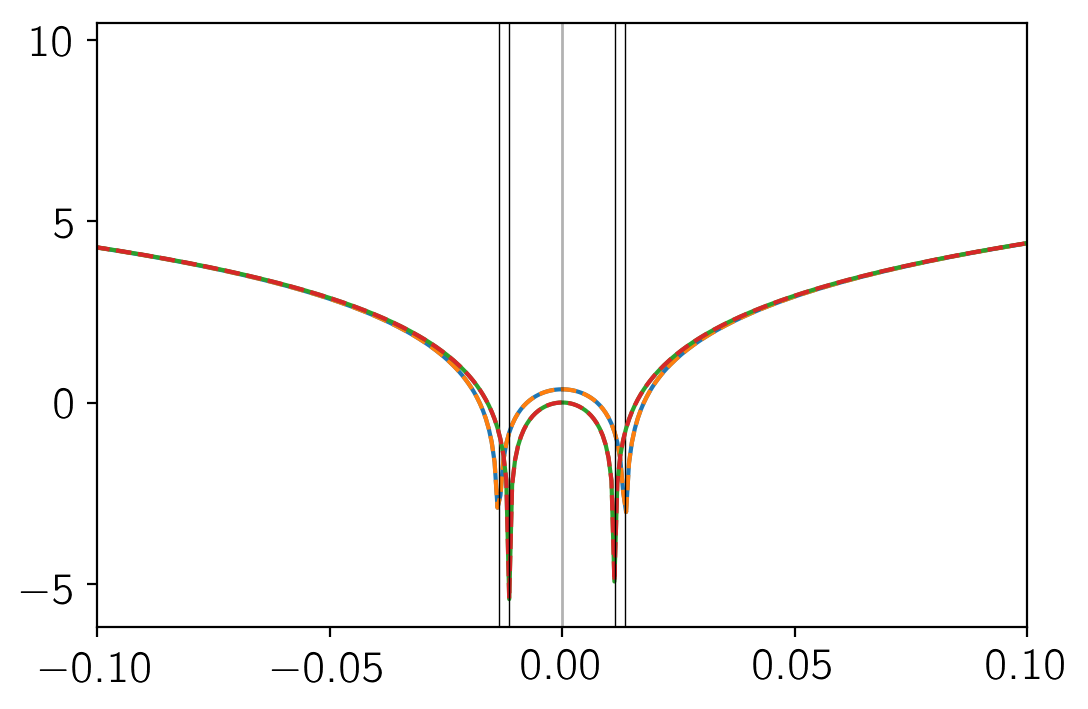

In [439]:
f = np.linspace(-np.pi, np.pi, 10000)

sinw = np.sin(omega)
cosw = np.cos(omega)
sini = np.sin(incl)
cosi = np.cos(incl)
f0 = 2*np.arctan2(cosw, 1 + sinw)

b2 = lambda f: semimajor**2*(ecc**2 - 1)**2*(cosi**2*(cosw*np.sin(f) + sinw*np.cos(f))**2 + (cosw*np.cos(f) - sinw*np.sin(f))**2)/(ecc*np.cos(f) + 1)**2
b2_old = lambda f: semimajor**2*(ecc**2 - 1)**2 * (np.sin(f - f0)**2 + np.cos(f - f0)**2 * cosi**2) / (1 - ecc * np.sin(f - f0 - omega))**2

for i in range(len(L)):
    for r in roots[i]:
        print(b2(r + f0))
    
    plt.plot(f - f0, np.log(np.abs(b2(f) - L[i]**2)))
    plt.plot(f - f0, np.log(np.abs(b2_old(f) - L[i]**2)), "--")
    [plt.axvline(r, color="k", lw=0.5) for r in roots[i]]
    
plt.axvline(0, color="k", alpha=0.3, lw=1)
plt.xlim(-0.1, 0.1)

In [442]:
roots[0].flat[0]

-0.013635817148505591